# 1.0 Introduction

The Full-Width Half Maximum (FWHM) of a diffraction peak varies with the level of ordering within a crystal. This allows the FWHM to be used as a metric to distinguish amorphous alloys from crystalline alloys.

Metallic glasses are amorphous and thus, FWHM measurement can be used to predict the glass-forming ability of alloys. More specifically, a threshold FWHM measurement can be set to allow for the classification of alloys as glass-forming or non-glass-forming.

This report uses K-nearest neighbor classification models on human-labelled data on the glass-forming ability of three ternary subsystems (CrTiZr, CrCoZr, CoTiZr), in order to predict the glass forming ability of the quaternery Co-Zr-Cr-Ti system.

# 2.0 Data Pre-processing and Exploration

In [1]:
### Import standard libraries
import pandas as pd
import scipy.io
import numpy.matlib as nm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import ternary
import scipy

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneGroupOut, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import Miedema, YangSolidSolution, Meredig

In [2]:
rng = 0 #random seed

In [3]:
# Loading each ternery system as a separate dataframe, assigning a "Group" label to each alloy
# https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
CrTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 0)
CrTiZr_data = CrTiZr_data.dropna(axis=1)
CrTiZr_data['Group'] = 1
CrCoZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 1)
CrCoZr_data = CrCoZr_data.dropna(axis=1)
CrCoZr_data['Group'] = 2
CoTiZr_data = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = 2)
CoTiZr_data = CoTiZr_data.dropna(axis=1)
CoTiZr_data['Group'] = 3

In [4]:
# Combine dataframes into one 
def combine_dataframes(df1, df2):
    common_columns = list(set(df1.columns) & set(df2.columns))
    # Merge dataframes on the common columns
    # https://sparkbyexamples.com/pandas/pandas-outer-join-explained-by-examples/#:~:text=Outer%20join%20is%20also%20called,returns%20null%20on%20respective%20cells.
    df_merged = pd.merge(df1, df2, on=common_columns, how='outer')
    # Put zeros for missing values
    df_merged.fillna(0, inplace=True)
    return df_merged

combined_data = combine_dataframes(CrTiZr_data, CrCoZr_data)
combined_data = combine_dataframes(CoTiZr_data, combined_data)
combined_data = combined_data[['Co', 'Ti', 'Zr','Cr','Glass (TRUE/FALSE)', 'Group']]

In [5]:
# Replace boolean true labels in "Glass (TRUE/FALSE)" with 1 or 0, where 1 indicates glass-forming and 0 is non-glass forming
# Used CoPilot
combined_data['Glass (TRUE/FALSE)'] = combined_data['Glass (TRUE/FALSE)'].apply(lambda x: 1 if x else 0)

# Replace 'Glass(TRUE/FALSE)' with Label simpler programming
combined_data = combined_data.rename(columns={'Glass (TRUE/FALSE)': 'Label'})

In [6]:
# Drop missing values, duplicates
combined_data = combined_data.dropna()
combined_data = combined_data.drop_duplicates()

In [7]:
# See if any features are highly correlated
combined_data.corr().iloc[:4,:4] > abs(0.8)

,Co,Ti,Zr,Cr
Co,True,False,False,False
Ti,False,True,False,False
Zr,False,False,True,False
Cr,False,False,False,True


No features are highly correlated and thus, none are dropped

# 2.1 Exploring class distribution within data set

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
# Used ChatGPT
def plot_class_distribution(labels, categories):
    """
    Plots the class distribution of true labels for each category.

    Args:
        labels (pandas.Series): A column containing the true labels (either 0 or 1) for each datapoint.
        categories (pandas.Series): A column containing the sample category for each datapoint.

    Returns:
        None
    """

    # Create a DataFrame from the input data.
    df = pd.DataFrame({'true_label': labels, 'category': categories})

    # Group the dataset by category and true label.
    group_counts = df.groupby(['category', 'true_label'])['true_label'].count()

    # Reformat the data as a nested dictionary for plotting.
    data = {}
    for category in group_counts.index.levels[0]:
        data[category] = {}
        for label in [0, 1]:
            if label in group_counts[category]:
                data[category][label] = group_counts[category, label]
            else:
                data[category][label] = 0

    # Set up the figure and axes for plotting.
    fig, ax = plt.subplots()

    # Set the width of each bar.
    bar_width = 0.35

    # Set the x positions of the bars.
    positions = []
    for i in range(len(data)):
        positions.append(i * (2 * bar_width + 0.1))

    # Set the colors for the bars.
    colors = ['tab:blue', 'tab:orange']

    # Plot the bars for each category and true label.
    for i, category in enumerate(data.keys()):
        bars_0 = ax.bar(positions[i] - bar_width, data[category][0], width=bar_width, color=colors[0], label=f'{category} - 0')
        bars_1 = ax.bar(positions[i], data[category][1], width=bar_width, color=colors[1], label=f'{category} - 1')

    # Add labels and a legend to the plot.
    ax.set_ylabel('Count')
    ax.set_xlabel('Ternary Alloy Group')
    ax.set_title('Count of glass-forming (orange) vs non-glass forming (blue) compositions per ternary alloy group')
    ax.set_xticks(positions)
    ax.set_xticklabels(data.keys())
#     ax.legend()

    # Display the plot.
    plt.show()


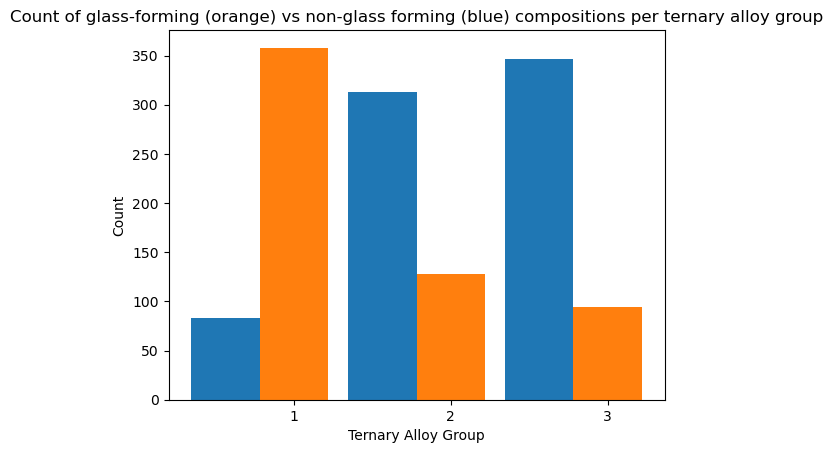

In [9]:
plot_class_distribution(combined_data.iloc[:,4], combined_data.iloc[:,5])

In [10]:
combined_data.iloc[:,4:6].groupby(['Group', 'Label'])['Label'].count()

Group  Label
1      0         83
       1        358
2      0        313
       1        128
3      0        347
       1         94
Name: Label, dtype: int64

Each ternary system has drastically different counts of compositions that correspond to glass forming/non- glass forming alloys. As a result, LOCO CV is expected to not work well.

In [11]:
num_ones = (combined_data['Label'] == 1).sum()
num_zeros = (combined_data['Label'] == 0).sum()
print(f'Number of ones (glass-forming alloys): {num_ones}')
print(f'Number of zeros (non-glass forming alloys): {num_zeros}')
print(f'Total percentage of glass-forming alloys in data: {round((num_ones) / (num_zeros + num_ones), 3) * 100}')

Number of ones (glass-forming alloys): 580
Number of zeros (non-glass forming alloys): 743
Total percentage of glass-forming alloys in data: 43.8


Overall, the data set does not have an even split between glass and non-glass forming alloys.

# 3.0 Helper Functions

In [12]:
"""
Used ChatGPT but I modified the code to use StratifiedShuffleSplit, perform standardization, and print test/train set class
distributions and errors
"""
def knn_cv(df, cv_type='loco', n_splits=5, n_neighbor=100):
    X = df.iloc[:, 2:11]
    y = df.iloc[:, 11]
    groups = df.iloc[:, 12]
    
    if cv_type == 'loco':
        cv = LeaveOneGroupOut()
        cv = cv.split(X, groups = groups)
    elif cv_type == 'kfold':
        # Random CV with shuffling and 80-20 train-test split
#         cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
        cv = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.2)
#         cv = ShuffleSplit(n_splits=n_splits, test_size=0.2)
        cv = cv.split(X, y)
    else:
        raise ValueError('Invalid cross-validation type. Choose "loco" or "kfold".')
        
    cv_scores = [] # Contains accuracy scores on test set of each fold
    test_errors = [] # Contains test set error of each fold
    train_errors = [] # Contains training set error of each fold
    
    for train_index, test_index in cv:
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Define model
        knn = KNeighborsClassifier(n_neighbors=n_neighbor)
        
        # Standardize features
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Get model predictions on testing data in fold
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        # Append accuracy score 
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores.append(accuracy)
        
        # Calculate training and testing set errors
        test_error = 1 - knn.score(X_test, y_test)
        train_error = 1 - knn.score(X_train, y_train)
        test_errors.append(test_error)
        train_errors.append(train_error)
        
        # plot confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure()
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xticks([0, 1])
        plt.yticks([0, 1])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.grid(False)
        for i in range(2):
            for j in range(2):
                plt.text(j, i, format(conf_matrix[i, j], '.2f'),
                         horizontalalignment="center",
                         color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")
        
        
#         print(f'Confusion Matrix - Fold {i+1}:\n{conf_matrix}')
        
        plt.show()
        
        # plot AUC-ROC curve
        y_score = knn.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = roc_auc_score(y_test, y_score)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
        # Print the class distribution of the training and test sets within each fold
        print(f'Train Set has {np.sum(y_train==0)} class 0 (non-MG) and {np.sum(y_train==1)} class 1 (MG)')
        print(f'Test Set has {np.sum(y_test==0)} class 0 (non-MG) and {np.sum(y_test==1)} class 1 (MG)')
        print(f'The non-MG : MG ratio in Train Set is {round(np.sum(y_train==0) / np.sum(y_train==1), 3)}')
        print(f'The non-MG : MG ratio in Test Set is {round(np.sum(y_test==0) / np.sum(y_test==1), 3)}')
        
        
        # Print test/train errors
        print(f'The training error is {round(train_error * 100, 4)} %')
        print(f'The test error is {round(test_error * 100, 4)} % ')
        

    return cv_scores, test_errors, train_errors

# 4.0 Dataset Featurization with Matminer

Using Miedema potential and Yang Solid Solution as additional features:

In [13]:
# Add chemical formula column to facilitate featurization with matminer
featurized_data = combined_data
formula = 'Co'+combined_data['Co'].astype(str)+'Ti'+combined_data['Ti'].astype(str)+'Zr'+combined_data['Zr'].astype(str)+'Cr'+combined_data['Cr'].astype(str)
featurized_data['Formula'] = pd.DataFrame(formula)
featurized_data = featurized_data[['Formula', 'Co', 'Ti', 'Zr','Cr','Label', 'Group']]

# #convert the formula from a string into chemical composition
featurized_data = StrToComposition().featurize_dataframe(featurized_data, "Formula")
featurized_data = Miedema().featurize_dataframe(featurized_data, col_id="composition")
featurized_data = YangSolidSolution().featurize_dataframe(featurized_data, col_id="composition")

StrToComposition:   0%|          | 0/1323 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1323 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1323 [00:00<?, ?it/s]

In [15]:
# Rearrange features for easier indexing
featurized_data_rearranged = featurized_data[['Formula','composition','Co', 'Ti', 'Zr', 'Cr', 'Miedema_deltaH_inter', 'Miedema_deltaH_amor', 'Miedema_deltaH_ss_min',
 'Yang omega', 'Yang delta', 'Label', 'Group']]

# 5.0 Testing model generalizability by performing cross validation

For clustering, k = 2 was used since we are performing binary classification. Interestingly, when I performed interia analysis I also received an elbow at k = 2, which suggests there is an underlying distribution of the data to be split into two classes. Of course, it is also very likely that this split does not physically correspond to the glass-forming ability of each alloy.

## 5.2 Performing LOCO-CV by splitting the featurized dataset by ternary systems

The confusion matrix, AUC-ROC curve, k-fold class distribution and training and testing error rates are shown below for each fold.

C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

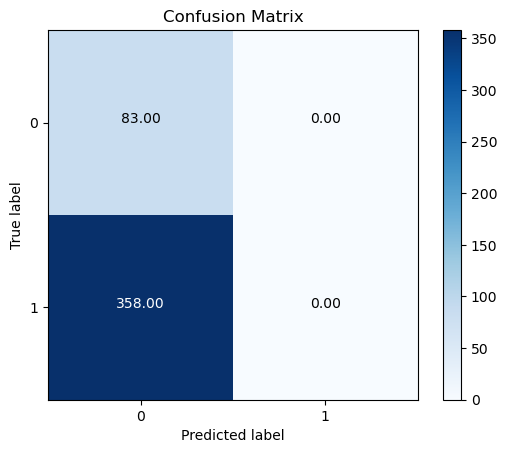

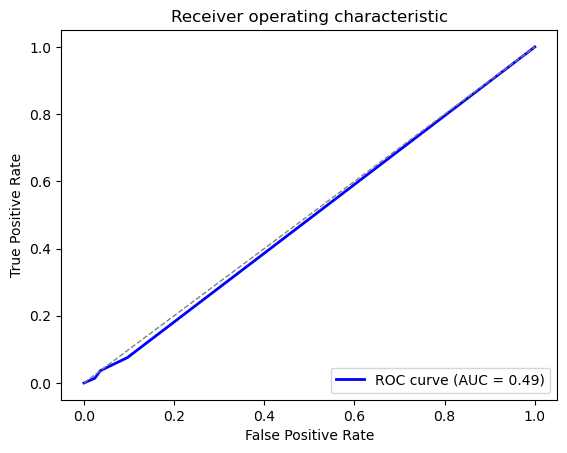

Train Set has 660 class 0 (non-MG) and 222 class 1 (MG)
Test Set has 83 class 0 (non-MG) and 358 class 1 (MG)
The non-MG : MG ratio in Train Set is 2.973
The non-MG : MG ratio in Test Set is 0.232
The training error is 2.6077 %
The test error is 81.1791 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

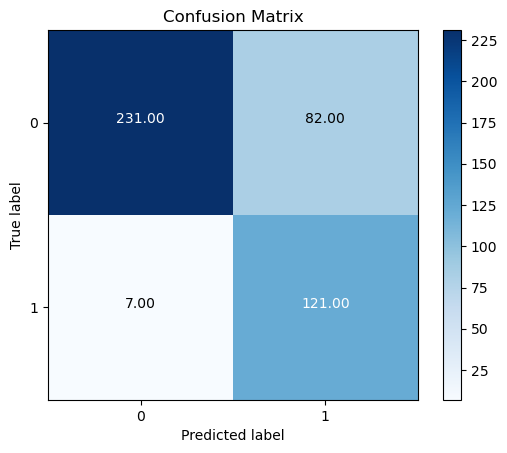

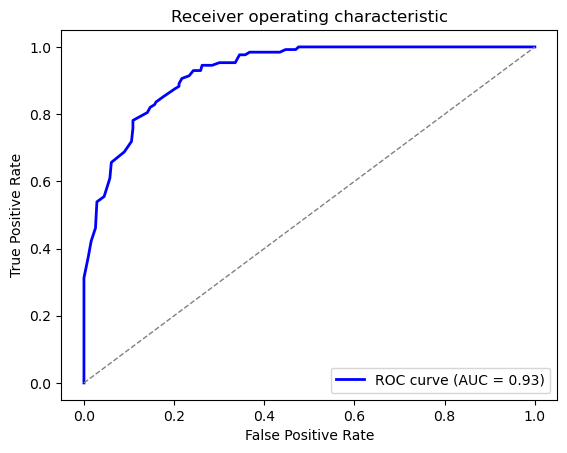

Train Set has 430 class 0 (non-MG) and 452 class 1 (MG)
Test Set has 313 class 0 (non-MG) and 128 class 1 (MG)
The non-MG : MG ratio in Train Set is 0.951
The non-MG : MG ratio in Test Set is 2.445
The training error is 7.9365 %
The test error is 20.1814 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

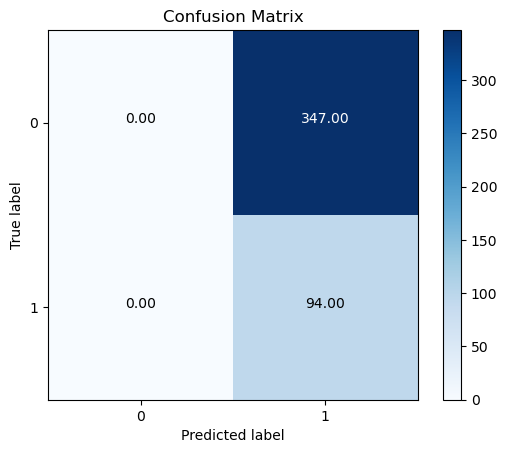

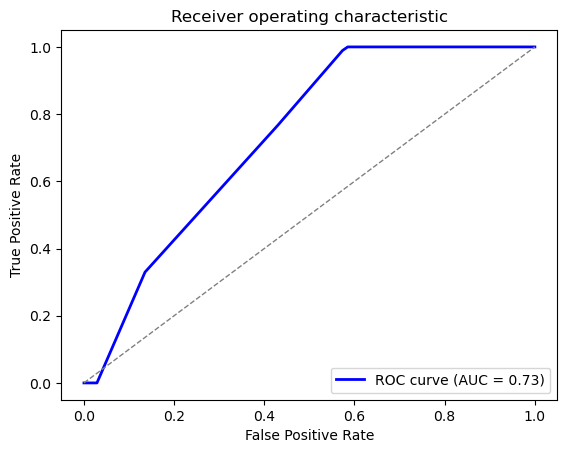

Train Set has 396 class 0 (non-MG) and 486 class 1 (MG)
Test Set has 347 class 0 (non-MG) and 94 class 1 (MG)
The non-MG : MG ratio in Train Set is 0.815
The non-MG : MG ratio in Test Set is 3.691
The training error is 8.0499 %
The test error is 78.6848 % 


In [16]:
lococv, locotest, locotrain = knn_cv(featurized_data_rearranged, cv_type='loco', n_splits=5)

## 5.2 Performing Random-CV

To ensure that the test and train error rates are more indicative of the predictive power of the model, I use StratifiedShuffleSplit which divides the data into _K_ random-folds and within each fold, attempts to maintain the same class distrubtion within the test and training sets.

The confusion matrix, AUC-ROC curve, k-fold class distribution and training and testing error rates are shown below for each fold.

C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

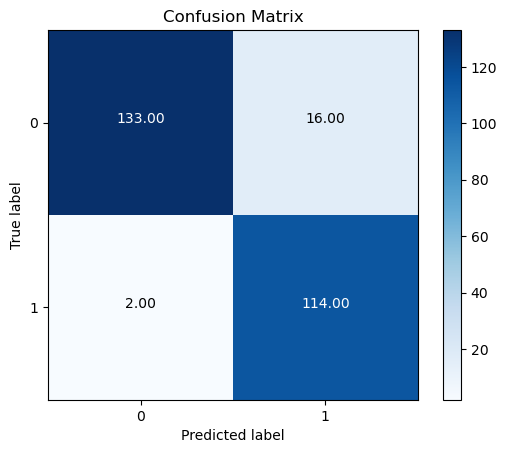

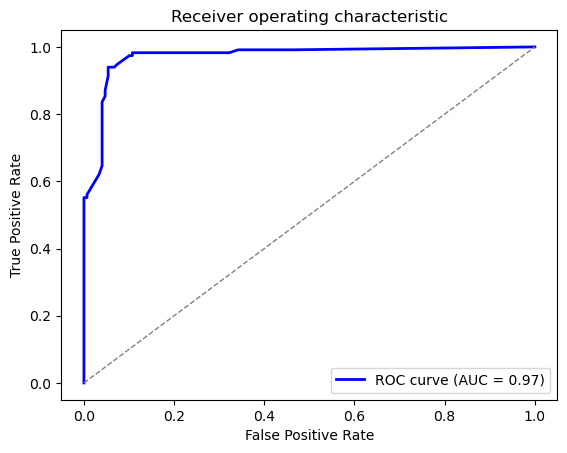

Train Set has 594 class 0 (non-MG) and 464 class 1 (MG)
Test Set has 149 class 0 (non-MG) and 116 class 1 (MG)
The non-MG : MG ratio in Train Set is 1.28
The non-MG : MG ratio in Test Set is 1.284
The training error is 6.3327 %
The test error is 6.7925 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

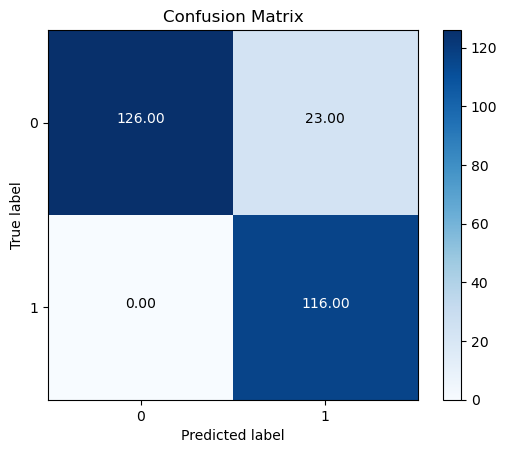

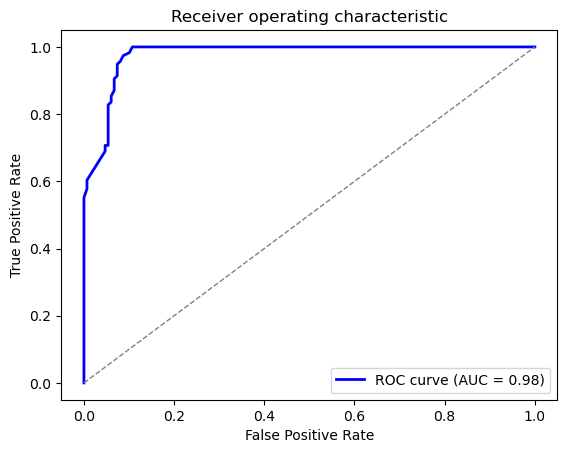

Train Set has 594 class 0 (non-MG) and 464 class 1 (MG)
Test Set has 149 class 0 (non-MG) and 116 class 1 (MG)
The non-MG : MG ratio in Train Set is 1.28
The non-MG : MG ratio in Test Set is 1.284
The training error is 7.9395 %
The test error is 8.6792 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

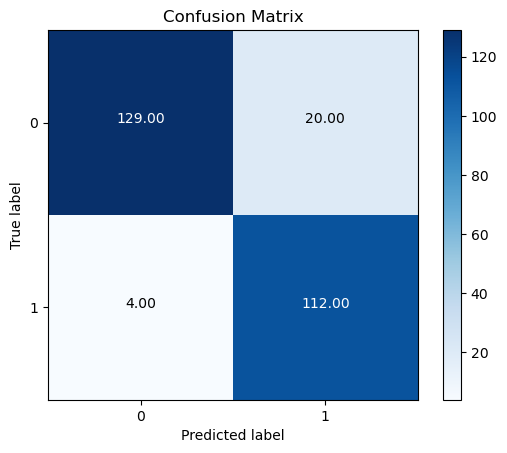

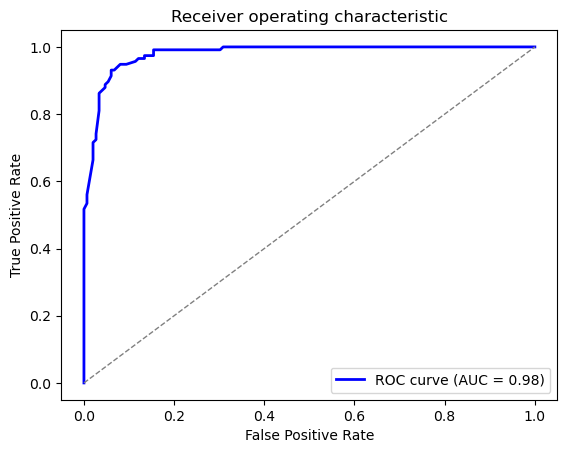

Train Set has 594 class 0 (non-MG) and 464 class 1 (MG)
Test Set has 149 class 0 (non-MG) and 116 class 1 (MG)
The non-MG : MG ratio in Train Set is 1.28
The non-MG : MG ratio in Test Set is 1.284
The training error is 7.845 %
The test error is 9.0566 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

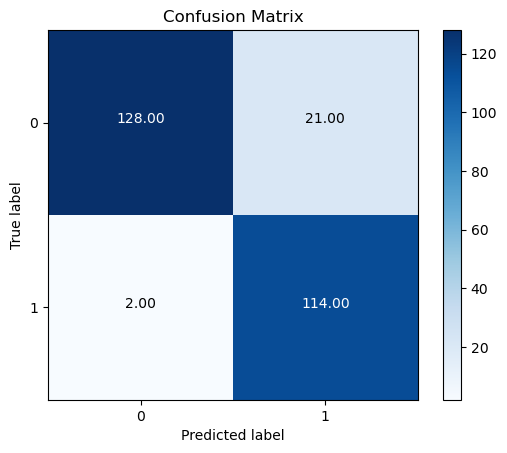

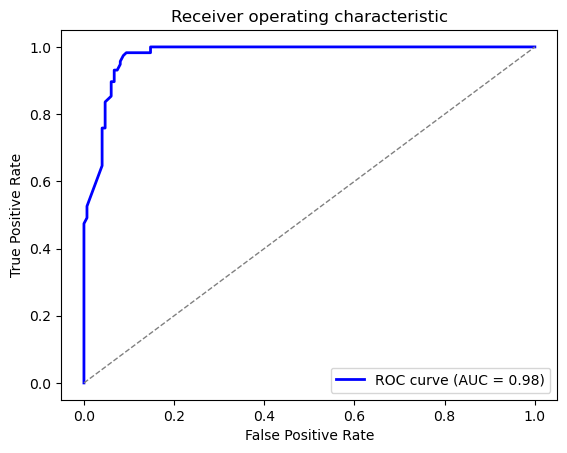

Train Set has 594 class 0 (non-MG) and 464 class 1 (MG)
Test Set has 149 class 0 (non-MG) and 116 class 1 (MG)
The non-MG : MG ratio in Train Set is 1.28
The non-MG : MG ratio in Test Set is 1.284
The training error is 8.2231 %
The test error is 8.6792 % 


C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

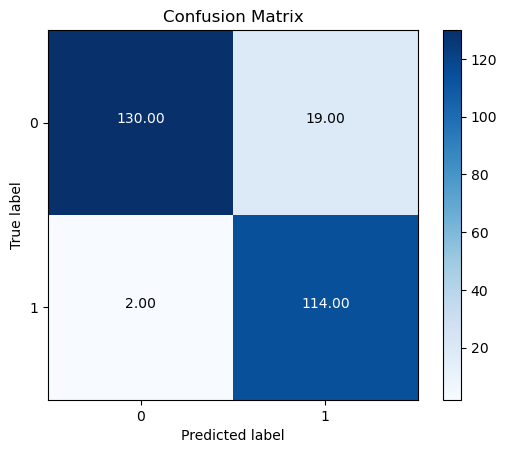

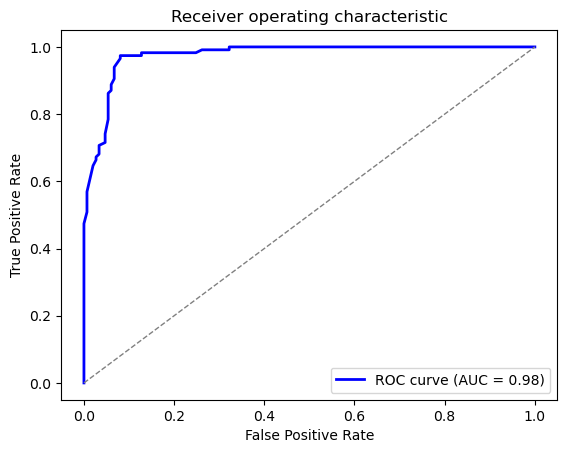

Train Set has 594 class 0 (non-MG) and 464 class 1 (MG)
Test Set has 149 class 0 (non-MG) and 116 class 1 (MG)
The non-MG : MG ratio in Train Set is 1.28
The non-MG : MG ratio in Test Set is 1.284
The training error is 8.034 %
The test error is 7.9245 % 


In [17]:
# Performing random 5 fold cross validation
randomcv, randomtest, randomtrain = knn_cv(featurized_data_rearranged, cv_type='kfold', n_splits=5)

# 6.0 Training a full data composition model

In [18]:
full_X = featurized_data_rearranged.iloc[:, 2:11]
full_y = featurized_data_rearranged.iloc[:, 11]

# Define full data model
full_data_knn = KNeighborsClassifier(n_neighbors=100)

# Standardize features
full_data_model_scaler = StandardScaler()
full_data_model_scaler.fit(full_X)
full_X = full_data_model_scaler.transform(full_X)

# Get model predictions on testing data in fold
full_data_knn.fit(full_X, full_y)

# Get AUC score of full data model
AUC = roc_auc_score(full_y, full_data_knn.predict_proba(full_X)[:, 1])
AUC

0.9822214229359075

# 7.0 Predicting the Glass forming ability for the entire Co-Zr-Cr-Ti quaternary phase diagram

In [19]:
# Used ChatGPT
# Define the elements of the alloy
elements = ['Co', 'Ti', 'Zr', 'Cr']

# Define the increment for atomic fractions
increment = 0.05

# Create an empty list to store the rows of the DataFrame
rows = []

# Generate all possible combinations of atomic fractions
for i in range(0, 21):
    for j in range(0, 21):
        for k in range(0, 21):
            # Compute the atomic fraction for the last element
            l = 20 - i - j - k
            if l < 0:
                continue
            # Compute the atomic fractions for each element
            atomic_fractions = [i*increment, j*increment, k*increment, l*increment]
            # Check if the total atomic fraction is equal to 1
            total_atomic_fraction = sum(atomic_fractions)
            if total_atomic_fraction == 1:
                rows.append(atomic_fractions)

# Create a DataFrame from the list of rows
quaternary_data = pd.DataFrame(rows, columns=elements)

In [20]:
formula = 'Co'+quaternary_data['Co'].astype(str)+'Ti'+quaternary_data['Ti'].astype(str)+'Zr'+quaternary_data['Zr'].astype(str)+'Cr'+quaternary_data['Cr'].astype(str)
quaternary_data['Formula'] = pd.DataFrame(formula)
quaternary_data = quaternary_data[['Formula', 'Co', 'Ti', 'Zr','Cr']]
quaternary_data = StrToComposition().featurize_dataframe(quaternary_data, "Formula")
quaternary_data = Miedema().featurize_dataframe(quaternary_data, col_id="composition")
quaternary_data = YangSolidSolution().featurize_dataframe(quaternary_data, col_id="composition")

StrToComposition:   0%|          | 0/1584 [00:00<?, ?it/s]

Miedema:   0%|          | 0/1584 [00:00<?, ?it/s]

YangSolidSolution:   0%|          | 0/1584 [00:00<?, ?it/s]

In [21]:
quaternary_data = quaternary_data[['Formula','composition', 'Co', 'Ti', 'Zr', 'Cr',
       'Miedema_deltaH_inter', 'Miedema_deltaH_amor', 'Miedema_deltaH_ss_min',
       'Yang omega', 'Yang delta']]

In [23]:
# Standardize test data (0.05 increment compositions) using training data (ternery compositions)
quaternary_data_X = quaternary_data.iloc[:,2:].astype(float)
quaternary_data_X_scaled = full_data_model_scaler.transform(quaternary_data_X)

In [24]:
# Predict on quaternary data
quaternary_data_model_predictions = full_data_knn.predict(quaternary_data_X_scaled)

C:\Users\karth\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [25]:
final_data = quaternary_data[['Co','Ti','Zr','Cr','Yang omega','Yang delta']]
# final_data['Matminer Model FWHM'] = pd.DataFrame(predictions_matminer_model)
final_data['Prediction'] = pd.DataFrame(quaternary_data_model_predictions)

C:\Users\karth\AppData\Local\Temp\ipykernel_8068\785807984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Prediction'] = pd.DataFrame(quaternary_data_model_predictions)


In [26]:
#Predict probability of a point belonging to the MG class
proba = full_data_knn.predict_proba(quaternary_data_X_scaled)[:,0]
final_data['Probability'] = pd.DataFrame(proba)

C:\Users\karth\AppData\Local\Temp\ipykernel_8068\3512842329.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Probability'] = pd.DataFrame(proba)


## 7.2 Plotting model predictions on Yang Plots by the label of glass forming/not forming

In [27]:
def percent_fmt(x, pos):
    return f"{x*100:.0f}%"

# Used ChatGPT and modified code
def plot_dataframe(df, color_col):
    # Extract the x, y, and color values from the DataFrame
    x = df.loc[:, 'Yang delta']
    y = df.loc[:, 'Yang omega']
    c = df[color_col]
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c)
    
    # Add labels and a color bar
    ax.set_xlabel(df.columns[5])
    ax.set_ylabel(df.columns[4])
    cbar = fig.colorbar(ax.collections[0])
    cbar.set_label(color_col)  # Add label to the color bar
    
    # Format the x-axis as percentages
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
    
    # Show the plot
    plt.title(f"Yang Plot of {color_col} values")
    plt.show()

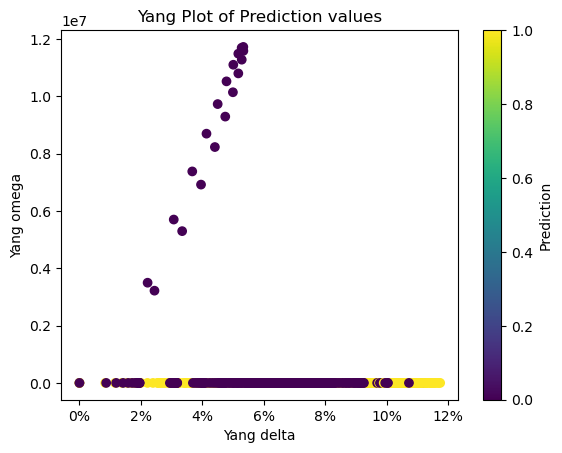

In [28]:
plot_dataframe(final_data, "Prediction")

This Yang plot is difficult to interpret; from the histograms below (commented out for concision), it is clear that the range of the Yang omega axis should be limited from 0 to ~5:

In [29]:
def plot_histogram(dataframe, column_name):
    plt.hist(dataframe[column_name])
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of ' + column_name)
    plt.show()
    
# plot_histogram(final_data, "Yang omega")
# plot_histogram(final_data, "Yang delta")

In [30]:
def percent_fmt(x, pos):
    return f"{x*100:.0f}%"

# Used ChatGPT and modified code
def plot_dataframe(df, color_col, overlay_rect=False, title=None):
    # Extract the x, y, and color values from the DataFrame
    x = df.loc[:, 'Yang delta']
    y = df.loc[:, 'Yang omega']
    c = df[color_col]
    
    # Create a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c)
    
    # Add labels and a color bar
    ax.set_xlabel(df.columns[5])
    ax.set_ylabel(df.columns[4])
    cbar = fig.colorbar(ax.collections[0])
    cbar.set_label(color_col)  # Add label to the color bar
    
    # Format the x-axis as percentages
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
    ax.set_ylim(bottom=0, top= 5)
    
    if overlay_rect:
        rect = patches.Rectangle((0.05, 0.3), 0.13, 1.2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.title(f"Yang Plot of Glass Formation Predictions")
    if color_col == "Prediction":
        caption = f"1 indicates glass-forming (yellow), 0 indicates not glass-forming (purple)"
        ax.text(0.5, -0.2, caption, transform=ax.transAxes, ha='center')
    if title:
        plt.title(title)
        
    plt.show()

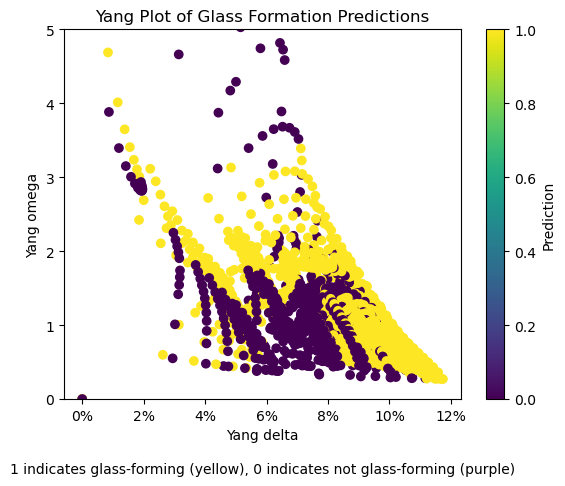

In [31]:
plot_dataframe(final_data, "Prediction")

## 7.3 Yang plot of model predictions colored by class probability

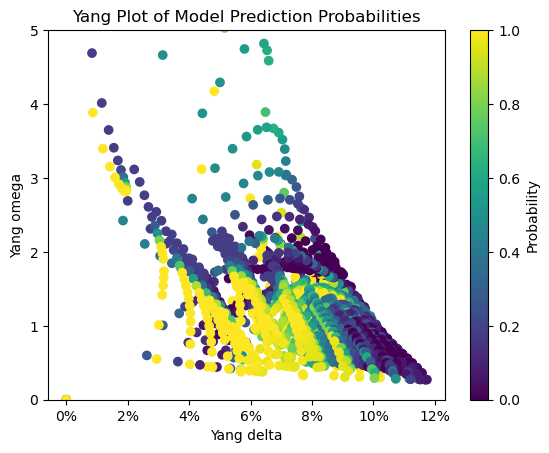

In [32]:
plot_dataframe(final_data, "Probability", overlay_rect = False, title = "Yang Plot of Model Prediction Probabilities")

## 7.4 Graphs comparing the location of training data versus model predictions


In [33]:
# Get yang omega and yang delta of both training and test data
full_training_data = featurized_data_rearranged.loc[:,['Yang omega', 'Yang delta', 'Label']]
full_training_data['Group'] = 'r'
full_prediction_data = final_data.loc[:,['Yang omega', 'Yang delta', 'Prediction']]
full_prediction_data = full_prediction_data.rename(columns={'Prediction': 'Label'})
full_prediction_data['Group'] = 'b'

In [34]:
# full_training_data_mg = full_training_data_mg[]

#Splitting training data into MG and non-MG groups
full_training_data_not_mg = full_training_data.loc[full_training_data['Label'] == 0]
full_training_data_mg = full_training_data.loc[full_training_data['Label'] == 1]

# Doing the same for model predictions
full_prediction_data_not_mg = full_prediction_data.loc[full_prediction_data['Label'] == 0]
full_prediction_data_mg = full_prediction_data.loc[full_prediction_data['Label'] == 1]

# Make dataframe consisting of model and training metallic glasses, and model and training non-MG:
full_training_and_prediction_data_mg = pd.concat([full_training_data_mg, full_prediction_data_mg])
full_training_and_prediction_data_not_mg = pd.concat([full_training_data_not_mg, full_prediction_data_not_mg])

A graph comparing the location of the training data location of __glass-forming alloys__ and the model's predictions of the same is shown below:

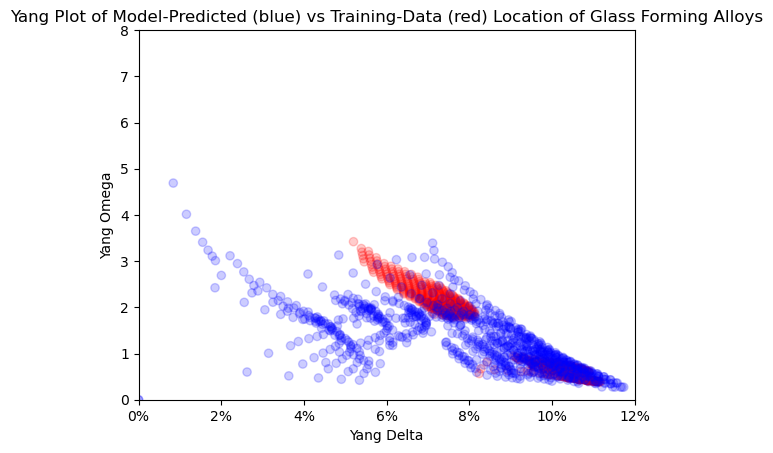

In [35]:
# Compare location of model-predicted MGs and training data MGs
fig, ax = plt.subplots()
ax.scatter(x=full_training_and_prediction_data_mg.iloc[:,1], 
           y=full_training_and_prediction_data_mg.iloc[:,0], 
           c=full_training_and_prediction_data_mg.iloc[:, 3], alpha = 0.2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
ax.set_ylim(bottom=0, top= 8)
ax.set_xlim(left=0, right= 0.12)
# plt.legend(loc='best')
plt.xlabel("Yang Delta")
plt.ylabel("Yang Omega")
plt.title("Yang Plot of Model-Predicted (blue) vs Training-Data (red) Location of Glass Forming Alloys")
plt.show()

A graph comparing the location of the training data location of __non-glass-forming alloys__ and the model's predictions of the same is shown below:

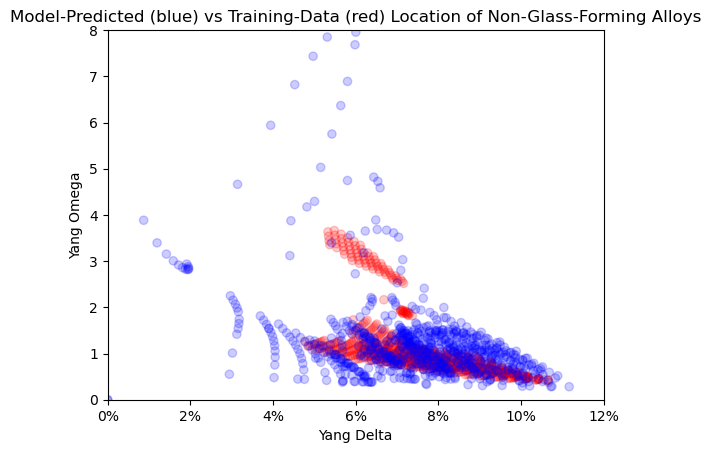

In [36]:
# Compare location of model-predicted non-MGs and training data non-MGs
fig, ax = plt.subplots()
ax.scatter(x=full_training_and_prediction_data_not_mg.iloc[:,1], 
           y=full_training_and_prediction_data_not_mg.iloc[:,0], 
           c=full_training_and_prediction_data_not_mg.iloc[:, 3], alpha = 0.2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(percent_fmt))
ax.set_ylim(bottom=0, top= 8)
ax.set_xlim(left=0, right= 0.12)
# plt.legend(loc='best')
plt.xlabel("Yang Delta")
plt.ylabel("Yang Omega")
plt.title("Model-Predicted (blue) vs Training-Data (red) Location of Non-Glass-Forming Alloys")
plt.show()

# 8.0 Summary

The model that was training appears to be somewhat reasonable, as the AUC scores of the various cross-validation folds are high (Section 5), which suggests that the model is able to distinguish between glass-forming and non-glass forming alloys well. Section 7.4, however, does indicate that the model's ability to produce physically-reasonable predictions may be limited since many of the datapoints of the model-predicted glass -forming/-non-forming alloys (blue dots) are outside of the region of the training data points (red dots). This is further confirmed when we consider the Yang heuristic (red rectangle), as showon in the plot below:

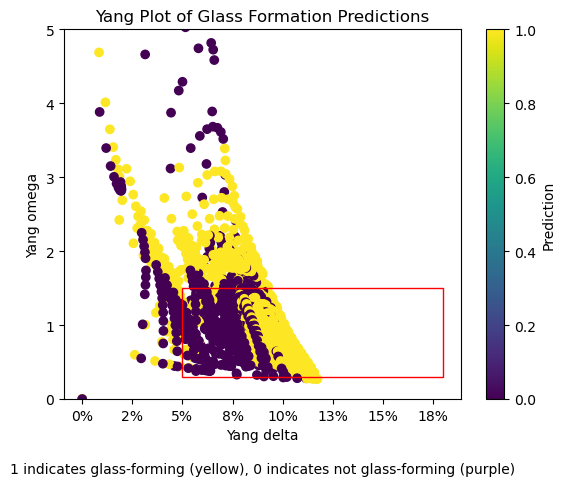

In [37]:
plot_dataframe(final_data, "Prediction", overlay_rect=True)

This graph shows that many of the alloys the models predicts to have glass-forming ability lie outside of Yang's metallic glass regime. Furthermore, the model also predict that many points in this regime do not have glass-forming abilities (purple dots), and so the model does not fully align with physical reality.

Similar to the previous lab, the validation statistics of random cross-validation are higher than that of LOCO cross validation. This is most likely due to better class balance between test and training sets of random CV, compared to LOCO-CV (the distribution of glass-forming vs non-glass forming compositions was visualized in Section 2.1).

Including features based on thermodynamics, such as entropy value of mixing and enthalpy, could also inform how likly an alloy can form a stable precursor to a metallic glass. 

The predictions in this lab vary significantly from those in our practice labs, which may be due to the fact that the bias in the data labels here is from human labelling, whereas in our labs we had conducted clustering to determine whether a particular composition had ability to form a glass. 
